In [160]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV

import statsmodels.formula.api as smf

from linearmodels.panel import PanelOLS

from mlxtend.plotting import scatterplotmatrix 

from stargazer.stargazer import Stargazer
import statistics

# Data Manipulation 

### Importing data 

In [161]:
# Sustainable development atlas of Bolivia 

bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/sdg_atlas_bolivia/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})

# Remote sensing data 

sat = pd.read_csv("data/satellite/satelite_data.csv")
#list(sat.columns)

#list(bol.columns)

In [162]:
bol["dep"].value_counts()

dep
La Paz        87
Santa Cruz    56
Cochabamba    47
Potosí        40
Oruro         35
Chuquisaca    29
Beni          19
Pando         15
Tarija        11
Name: count, dtype: int64

### SDG Indexes 

In [163]:
# creating a dataframe with only the composite sdg indexes

sdg_indexes = bol[["id", 'mun_id' , 'index_sdg1','index_sdg2','index_sdg3','index_sdg4','index_sdg5','index_sdg6','index_sdg7', 'index_sdg8','index_sdg9','index_sdg10',
               'index_sdg11','index_sdg13','index_sdg15','index_sdg16','index_sdg17', "imds",]]

#sdg_indexes.isna().sum()

# Export the index variables 
sdg_indexes.to_csv("data/sdg_prediction/sdg_indexes.csv", index=False)

### SDG Indicators 

In [164]:
sdg_indicators = bol[['id','sdg1_4_abs', 'sdg1_1_dtl_abs', 'sdg1_1_pubn_abs', 'sdg1_2_dd_abs', 'sdg1_4_ebs_abs', 'sdg2_2_cm_abs', 'sdg2_2_wow_abs', 'sdg2_4_apu_abs',
                    'sdg2_4_tm_abs', 'sdg3_2_fb_abs', 'sdg3_2_ffb_abs', 'sdg3_3_cd_abs','sdg3_3_pd_abs', 'sdg3_3_mc_abs', 'sdg3_3_tc_abs', 'sdg3_3_vih_abs',
                    'sdg3_7_bpw_abs', 'sdg4_1_mhs_abs', 'sdg4_1_fhs_abs', 'sdg4_4_heu_abs','sdg4_6_pnl_abs', 'sdg4_c_uti_abs', 'sdg4_c_uts_abs', 'sdg6_1_wdc_abs',
                    'sdg6_2_bsc_abs', 'sdg7_1_wec_abs', 'sdg7_1_rec_abs', 'sdg7_1_cec_abs','sdg7_3_tee_abs', 'sdg8_4_rem_abs', 'sdg8_5_ompr_abs',
                    'sdg8_5_ofpr_abs', 'sdg8_6_mlm_abs', 'sdg8_6_wlm_abs','sdg8_10_dbb_abs', 'sdg9_1_rmun_abs', 'sdg9_5_kcd_abs',
                    'sdg9_5_eutf_abs', 'sdg9_c_hf_abs', 'sdg9_c_tr_abs', 'sdg10_2_dss_abs','sdg11_1_ho_abs', 'sdg11_1_wos_abs', 'sdg11_2_mtv_abs',
                    'sdg13_2_tco2_abs', 'sdg13_2_ad_abs', 'sdg15_1_pa_abs','sdg15_5_rl_abs', 'sdg16_1_rh_abs', 'sdg16_6_aob_abs','sdg16_9_ncr_abs', 'sdg17_5_tpi_abs']]

sdg_indicators = sdg_indicators.fillna(0)
#Normalize the y variable 
sdg_indicators_norm = (sdg_indicators-sdg_indicators.mean())/sdg_indicators.std()

sdg_indicators_norm.to_csv("data/sdg_prediction/sdg_indicators_norm.csv", index=False)

### Air Temperature

In [165]:
# Air temperature

air_temp = pd.read_csv("data/satellite/air_temperature UDel.csv")
air_temp = air_temp.drop(columns={"asdf_id",'Level', 'gqid', 'shapeGroup', 'shapeID', 'shapeType', "shapeName"})

#Filter data columns 
air_temp_col = air_temp.loc[:, air_temp.columns.str.contains("20")]

# Changing first part of the name 
for col in air_temp_col:
    new_name = "airTemp" + col.split(".", 1)[1]
    air_temp = air_temp.rename(columns = {col:new_name});

air_temp_2013 = air_temp[["id", 'airTemp2013.max', 'airTemp2013.mean', 'airTemp2013.min']]
air_temp_2012 = air_temp[["id",'airTemp2012.max', 'airTemp2012.mean', 'airTemp2012.min']]    



### Distance to coast

In [166]:
coast = pd.read_csv("data/satellite/Distance to coast.csv")
coast = coast.drop(columns = {"asdf_id",'Level', 'gqid', 'shapeGroup', 'shapeID', 'shapeType', "shapeName"})
coast_col = coast.loc[:, coast.columns.str.contains("236")] 

for col in coast_col: 
    new_name = "distance_to_coast_" + col.split(".",2)[2]
    coast.rename(columns = {col:new_name}, inplace=True)
    

### Distance to Diamond Deposits

In [167]:
dia = pd.read_csv("data/satellite/Distance to diamond deposits.csv")
dia.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID','shapeType'}, inplace=True)
dia_col = dia.loc[:, dia.columns.str.contains("2017")] 

for col in dia_col: 
    new_name = "diamond2017" + col.split(".",2)[2]
    dia.rename(columns = {col:new_name}, inplace=True)

#dia.isna().sum()

### Distance to drug cultivation 

In [168]:
offset = 10 
dist_drug = pd.read_csv("data/satellite/Distance to drug cultivation.csv")
dist_drug = dist_drug.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
dist_drug_col = dist_drug.loc[:, dist_drug.columns.str.contains("drug")]

for col in dist_drug_col: 
    new_name = "dist_drug2017" + col.split(".",2)[2]
    dist_drug.rename(columns = {col:new_name}, inplace = True)

#drug_cult.isna().sum()

### Distance to road

In [169]:
road = pd.read_csv("data/satellite/Distance to road.csv")
road = road.drop(columns = {'asdf_id', 'Level', 'gqid', 'shapeGroup', 'shapeID', 'shapeType', "shapeName"})
road_col = road.loc[:, road.columns.str.contains("road")]

for col in road_col: 
    new_name = "distance_road2017" + col.split(".",2)[2]
    road.rename(columns = {col:new_name}, inplace = True)


### Distance to water

In [170]:
water = pd.read_csv("data/satellite/distance to water.csv")
water = water.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID', 'shapeType', "shapeName"})
water_col = water.loc[:, water.columns.str.contains("water")]

for col in water_col: 
    new_name = "dist_water2017" + col.split(".",2)[2]
    water.rename(columns = {col:new_name}, inplace = True)

#water.isna().sum()

### Drug cultivation

In [171]:
offset = 10 
drug_cult = pd.read_csv("data/satellite/Drug cultivation site 2017.csv")
drug_cult = drug_cult.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
drug_cult_col = drug_cult.loc[:, drug_cult.columns.str.contains("categorical")]

for col in drug_cult_col: 
    new_name = "drug_cult2017" + col.split(".categorical_",1)[1]
    drug_cult.rename(columns = {col:new_name}, inplace = True)

#drug_cult.columns

### ESA Landcover

In [172]:
esa_land = pd.read_csv("data/satellite/ESA landcover 2012-2016.csv")

# 2012
esa_land2012 = esa_land.loc[:, esa_land.columns.str.contains("2012|id|name")]
esa_land2012 = esa_land2012.drop(columns = {'gqid', "asdf_id"})
esa_land2012_col = esa_land2012.loc[:, esa_land2012.columns.str.contains("categorical")]

for col in esa_land2012_col:
    new_name = "esa_land2012" + col.split("categorical",1)[1]
    esa_land2012.rename(columns = {col:new_name}, inplace=True)

# 2013
esa_land2013 = esa_land.loc[:, esa_land.columns.str.contains("2013|id|name")]
esa_land2013 = esa_land2013.drop(columns = {'gqid', "asdf_id"})
esa_land2013_col = esa_land2013.loc[:, esa_land2013.columns.str.contains("categorical")]

for col in esa_land2013_col:
    new_name = "esa_land2013" + col.split("categorical",1)[1]
    esa_land2013.rename(columns = {col:new_name}, inplace=True)

### GEE modis 

In [173]:
gee_modis = pd.read_csv("data/satellite/GEE modis 2012-2017.csv")

# 2012
gee_modis2012 = gee_modis[gee_modis["year"] == 2012]
gee_modis2012 = gee_modis2012.reset_index(drop=True)
gee_modis2012 = gee_modis2012.drop(columns = {'system:index','country','level','system:time_start','.geo',"year","name"})
gee_modis2012 = gee_modis2012.add_prefix("gee_")
gee_modis2012 = gee_modis2012.rename(columns = {"gee_id":"id"})


# 2013
gee_modis2013 = gee_modis[gee_modis["year"] == 2013]
gee_modis2013 = gee_modis2013.reset_index(drop=True)
gee_modis2013 = gee_modis2013.drop(columns = {'system:index','country','level','system:time_start','.geo',"year","name"})
gee_modis2013 = gee_modis2013.add_prefix("gee_")
gee_modis2013 = gee_modis2013.rename(columns = {"gee_id":"id"})


### GISA 

In [174]:
gisa = pd.read_csv("data/satellite/GISA 2012-2019.csv")
gisa = gisa.drop(columns = {'system:index','country','level','system:time_start','.geo'})

# 2012
gisa2012 = gisa[gisa["year"]==2012]
gisa2012 = gisa2012.rename(columns = {"total_area":"gisa2012"})

# 2013
gisa2013 = gisa[gisa["year"]==2013]
gisa2013 = gisa2013.rename(columns = {"total_area":"gisa2013"})
#gisa2012.isna().sum()

### GHSL

In [175]:
ghsl = pd.read_csv("data/satellite/global_human_settlement_layer.csv")
ghsl = ghsl.drop(columns=['system:index', 'country', 'level', 'system:time_start', '.geo', "year", "name"])
ghsl = ghsl.rename(columns = {"total_volume": "ghsl2015"})
ghsl["ln_ghsl2015"] = np.log(ghsl["ghsl2015"])

### Gold deposits

In [176]:
#gold =  pd.read_csv("data/satellite/Gold deposits.csv")

### Physical elevation 

In [177]:
elev = pd.read_csv("data/satellite/Physical Elevation.csv")
elev = elev.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
elev_col = elev.loc[:, elev.columns.str.contains("elevation")]

for col in elev_col:
    new_name = "elev2017" + col.split(".",2)[2]
    elev = elev.rename(columns = {col:new_name})

### Malaria atlas 

In [178]:
offset = 1000 

mala = pd.read_csv("data/satellite/Malaria Atlas.csv")
mala = mala.drop(columns = {'asdf_id','Level', 'gqid','shapeGroup','shapeID','shapeType',"shapeName"})

# 2012
mala2012 = mala.loc[:, mala.columns.str.contains("2012", regex=True)]
mala2012.reset_index(names="id", inplace=True)
mala2012_col = mala2012.loc[:, mala2012.columns.str.contains("rate")]

for col in mala2012_col:
    new_name = "mal_rt_2012" + col.split(".",2)[2]
    mala2012 = mala2012.rename(columns = {col:new_name})

# 2013
mala2013 = mala.loc[:, mala.columns.str.contains("2013", regex=True)]
mala2013.reset_index(names="id", inplace=True)
mala2013_col = mala2013.loc[:, mala2013.columns.str.contains("rate")]

for col in mala2013_col:
    new_name = "mal_rt_2013" + col.split(".",2)[2]
    mala2013 = mala2013.rename(columns = {col:new_name})

mala2013.columns

Index(['id', 'mal_rt_2013mean', 'mal_rt_2013min', 'mal_rt_2013max',
       'mal_rt_2013count'],
      dtype='object')

### Photovoltaic potential 

In [179]:
photo = pd.read_csv("data/satellite/Photovoltaic power potential.csv")
photo = photo.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
photo_col = photo.loc[:,photo.columns.str.contains("global")]

for col in photo_col:
    new_name = "photov2019" + col.split(".",2)[2]
    photo = photo.rename(columns = {col:new_name})

### Time to major city 

In [180]:
time_to_city = pd.read_csv("data/satellite/time to major city.csv")
time_to_city = time_to_city.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
time_to_city_col = time_to_city.loc[:, time_to_city.columns.str.contains("access")]

for col in time_to_city_col:
    new_name = "access2016" + col.split(".",2)[2]
    time_to_city = time_to_city.rename(columns = {col:new_name})

#time_to_city

### Precipitation CRU

In [181]:
prec = pd.read_csv("./data/satellite/Yearly precipitaiton CRU.csv")
prec = prec.drop(columns= {"gqid","asdf_id"})

# 2012
prec2012 = prec.loc[:,prec.columns.str.contains("2012|id")]
prec_2012col = prec.loc[:,prec.columns.str.contains("2012")]

for col in prec_2012col:
    new_name = "precCRU2012" + col.split(".", 2)[2]
    prec2012 = prec2012.rename(columns= {col:new_name})

# 2013
prec2013 = prec.loc[:,prec.columns.str.contains("2013|id")]
prec_2013col = prec.loc[:,prec.columns.str.contains("2013")]

for col in prec_2013col:
    new_name = "precCRU2013" + col.split(".", 2)[2]
    prec2013 = prec2013.rename(columns= {col:new_name})


### Ground Slope 

In [182]:
slope = pd.read_csv("./data/satellite/Ground Slope.csv")
slope = slope.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
slope_col = slope.loc[:, slope.columns.str.contains("slope")]

for col in slope_col:
    new_name = "slope500m2017" + col.split(".",2)[2]
    slope = slope.rename(columns= {col:new_name})

#slope

### Modis Landcover

In [183]:
# TODO: Create a df with the values for 2013

In [184]:
mod_landcover = pd.read_csv("./data/satellite/modis landcover.csv")
mod_landcover = mod_landcover.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', 
                                              "shapeName", 'modis_landcover_51.2012.categorical_unclassified',
                                              'modis_landcover_51.2012.categorical_fill_value', "id"})
mod_landcover_col = mod_landcover.loc[:, mod_landcover.columns.str.contains("modis")]

for col in mod_landcover_col: 
    new_name = "land_per_area_2012_" + col.split("_",3)[3]
    mod_landcover = mod_landcover.rename(columns={col:new_name})

# Creating Aggregated variables 
mod_landcover_percent = mod_landcover.div(mod_landcover['land_per_area_2012_count'], axis=0)*100
mod_landcover_percent.reset_index(names="id", inplace=True)

forest_col = mod_landcover.columns[mod_landcover.columns.str.contains("forest")]
mod_landcover_percent["land_per_area_2012_full_forest"] = (mod_landcover_percent.loc[:,forest_col]).sum(axis=1)

savannas_col = mod_landcover.columns[mod_landcover.columns.str.contains("savannas|Grasslands")]
mod_landcover_percent["land_per_area_2012_full_savannas_grasslands"] = (mod_landcover_percent.loc[:,savannas_col]).sum(axis=1)

shrublands_col = mod_landcover.columns[mod_landcover.columns.str.contains("shrublands")]
mod_landcover_percent["land_per_area_2012_full_shrublands"] = (mod_landcover_percent.loc[:,shrublands_col]).sum(axis=1)

mod_landcover_percent_clean = mod_landcover_percent[["id",
                                                    "land_per_area_2012_croplands",
                                                    "land_per_area_2012_full_forest",
                                                    'land_per_area_2012_urban_and_builtup',
                                                    "land_per_area_2012_full_savannas_grasslands",
                                                    "land_per_area_2012_full_shrublands",
                                                    'land_per_area_2012_cropland_natural_vegetation_mosaic']]
#mod_landcover_percent_clean

### Population density

In [185]:
density_pop = pd.read_csv("./data/satellite/Population density 2015.csv")
density_pop = density_pop.drop(columns = {'asdf_id','Level','gqid','shapeGroup', 'shapeID','shapeType', "shapeName"})
density_pop_col = density_pop.loc[:,density_pop.columns.str.contains("density")]

for col in density_pop_col: 
    new_name = "density_pop2015" + col.split(".",2)[2]
    density_pop = density_pop.rename(columns = {col:new_name})
#density_pop

## Create a dataframe with all satellite data


### Unify bol and sat data

### 2012 data 

In [186]:
# Satellite dataframes with the same construction 
dataframes = [coast,dia,dist_drug,road,water,drug_cult,esa_land2012, gee_modis2012, ghsl, elev, mala2012, gisa2012]

# Satellite data from the Bolivia dataset 

satellite_full = bol[["id", 'mun_id' , 'tr400_pop2012', "ln_t400NTLpc2012",'ln_t400NTLpc2020',]]

# Other satellite data
sat_filtered = sat[["id", 'egdp2012','agr_land2012','urb_land2012','pm25_2012','land_temp2012',]]

# Merging the satellite dataframes 
satellite_full = satellite_full.merge(sat_filtered, on="id", how="outer")
satellite_full = satellite_full.merge(air_temp_2012, on="id", how="outer")

for df in dataframes: 
    satellite_full = satellite_full.merge(df, on="id", how="outer")

# Export satellite data
#satellite_full.to_csv("data/sdg_prediction/satellite_full.csv")

#list(satellite_full.columns)

#satellite_full

### 2013 data

In [187]:
# Satellite dataframes with the same construction 
dataframes = [coast,dia,dist_drug,road,water,drug_cult,esa_land2013, gee_modis2013, ghsl, elev, mala2013, gisa2013]

# Satellite data from the Bolivia dataset 

satellite_full_2013 = bol[["id", 'mun_id' , 'tr400_pop2013', "ln_t400NTLpc2013",]]

# Other satellite data
sat_filtered2013 = sat[["id", 'egdp2013','agr_land2013','urb_land2013']]

# Merging the satellite dataframes 
satellite_full_2013 = satellite_full_2013.merge(sat_filtered2013, on="id", how="outer")
satellite_full_2013 = satellite_full_2013.merge(air_temp_2013, on="id", how="outer")

for df in dataframes: 
    satellite_full_2013 = satellite_full_2013.merge(df, on="id", how="outer")

# Export satellite data
#satellite_full.to_csv("data/sdg_prediction/satellite_full.csv")

#list(satellite_full.columns)

#satellite_full

### Create a df with the Relevant satellite data and its manipulations 

In [188]:
# Normalization functions 
def robust_scaling(df,var):
    q75, q25 = np.percentile(df[var],[75,25])
    iqr = q75-q25
    median = statistics.median(df[var])
    robust_scaling = (df[var] - median)/iqr
    return robust_scaling

def z_score(df, var):
    z_score = (df[var] - np.mean(df[var]))/np.std(df[var]) 
    return z_score

In [189]:
# Creation of the satellite dataframe
offset = 0.1  

sat_mod = pd.DataFrame()

# Identifiers  
sat_mod["id"] = satellite_full["id"]
sat_mod["dep"] = bol["dep"]

# Log EGDP per capita - sum EGDP
satellite_full["EGDPpc2012"] = (satellite_full["egdp2012"]*1000000/ bol["tr400_pop2012"])
sat_mod["lnEGDPpc2012"] = np.log(satellite_full["EGDPpc2012"])

# Land cover agriculture/urban
sat_mod["lnagr_land2012"] = np.log(satellite_full["agr_land2012"] + offset)
sat_mod["lnurb_land2012"] = np.log(satellite_full["urb_land2012"] + offset)

# Urban landcover percentage
satellite_full["total_land2012"] = satellite_full["agr_land2012"] + satellite_full["urb_land2012"]
satellite_full["perUrb_land2012"] = satellite_full["urb_land2012"] / satellite_full["total_land2012"]
sat_mod["perUrb_land2012"] = satellite_full["perUrb_land2012"].fillna(0)

# Population
sat_mod["ln_tr400_pop2012"] = np.log(satellite_full["tr400_pop2012"])

# PM2.5
sat_mod["ln_pm25_2012"] = np.log(satellite_full["pm25_2012"])

# Surface temperature
sat_mod["ln_land_temp2012"] = np.log(satellite_full["land_temp2012"])

# NTL
sat_mod["ln_t400NTLpc2012"] = satellite_full["ln_t400NTLpc2012"]

# Distance to road 
sat_mod["ln_dist_road2017"] = np.log(satellite_full["distance_road2017mean"]) 

# GHSL 
sat_mod["ln_ghsl2015"] = satellite_full["ln_ghsl2015"]

# Distance Diamond deposits 
sat_mod["dist_diamond2015"] = satellite_full["diamond2017mean"]

#Malaria Rate
sat_mod['mal_rt_2012max'] = mala2012['mal_rt_2012max']
sat_mod['ln_mal_rt_2012max'] = np.log(mala2012['mal_rt_2012max']+offset)

#Distance to water 
sat_mod["ln_dist_water2017mean"] = np.log(water["dist_water2017mean"])

# Physical Elevation 
sat_mod['ln_elev2017mean'] = np.log(elev['elev2017mean']+offset)
#sat_mod['norm_ln_elev2017mean'] = robust_scaling(elev, 'elev2017mean')

# Distance to Drug cultivation
sat_mod["ln_dist_drug2017mean"] = np.log(dist_drug["dist_drug2017mean"]+offset)

# Photovoltaic Potential 
sat_mod['photov2019mean'] = photo['photov2019mean']

# Time to major city 
sat_mod["access2016mean"] = time_to_city["access2016mean"]
sat_mod["ln_access2016mean"] = np.log(sat_mod["access2016mean"])

# Slope
sat_mod["slope500m2017mean"] = slope["slope500m2017mean"]
sat_mod["ln_slope500m2017mean"] = np.log(slope["slope500m2017mean"])

sat_mod["precCRU2012mean"] = prec2012["precCRU2012mean"]
sat_mod["ln_precCRU2012mean"] = np.log(prec2012["precCRU2012mean"])

sat_mod["ln_density_pop2015count"] = np.log(density_pop["density_pop2015count"])

sat_mod = sat_mod.merge(mod_landcover_percent_clean, on="id", how="outer")
sat_mod = sat_mod.merge(air_temp_2012, on="id", how="outer")

sat_mod.to_csv("data/sdg_prediction/sat_mod.csv", index=False)

### Unmodified labels data

In [ ]:
### labels data

sat_true = pd.DataFrame()

# Identifiers  
sat_true["id"] = satellite_full["id"]
sat_true["dep"] = bol["dep"]

# Log EGDP per capita - sum EGDP
satellite_full["EGDPpc2012"] = (satellite_full["egdp2012"]*1000000/ bol["tr400_pop2012"])

# Land cover agriculture/urban
sat_true["agr_land2012"] = satellite_full["agr_land2012"]
sat_true["urb_land2012"] = satellite_full["urb_land2012"]

# Urban landcover percentage
satellite_full["total_land2012"] = satellite_full["agr_land2012"] + satellite_full["urb_land2012"]
sat_true["perUrb_land2012"] = satellite_full["urb_land2012"] / satellite_full["total_land2012"]
sat_true["perUrb_land2012"] = satellite_full["agr_land2012"] / satellite_full["total_land2012"]

# Population
sat_true["tr400_pop2012"] = satellite_full["tr400_pop2012"]

# PM2.5
sat_true["pm25_2012"] = satellite_full["pm25_2012"]

# Surface temperature
sat_true["land_temp2012"] = satellite_full["land_temp2012"]

# NTL
sat_true["ln_t400NTLpc2012"] = satellite_full["ln_t400NTLpc2012"]

# Distance to road 
sat_true["dist_road2017"] = satellite_full["distance_road2017mean"]

# GHSL 
sat_true["ghsl2015"] = ghsl["ghsl2015"]

# Distance Diamond deposits 
sat_true["dist_diamond2015"] = satellite_full["diamond2017mean"]

#Malaria Rate
sat_true["mal_inci_rt_mean"] = mala2012["mal_inci_rt_mean"]

#Distance to water
sat_true["dist_water2017mean"] = water["dist_water2017mean"]

# Physical Elevation 
sat_true['elev2017mean'] = elev['elev2017mean']

# Distance to Drug cultivation
sat_true["dist_drug2017mean"] = dist_drug["dist_drug2017mean"]

# Photovoltaic Potential 
sat_true['photov2019mean'] = photo['photov2019mean']

# Time to major city 

sat_true["access2016mean"] = time_to_city["access2016mean"]


sat_true["slope500m2017mean"] = slope["slope500m2017mean"]


sat_true["precCRU2012mean"] = prec["precCRU2012mean"]

sat_true["density_pop2015count"] = density_pop["density_pop2015count"]

sat_true = sat_true.merge(mod_landcover_percent, on="id", how="outer")
list(sat_true.columns)

sat_true.to_csv("data/sdg_prediction/sat_true.csv", index=False)

### Features names 

In [ ]:
feature_name = ["Log EGDP", 
            "Agricultural land", 
            "Urban land",
            "Percentage of urban land",
            "Log Population",
            "Log PM2.5",
            "log Land temperature",
            "Log NTL",
            "Log Distance to road",
            "Log GHSL",
            "Distance to Diamonds Extraction site", 
            "Log Malaria rate",
            "Log Distance to water",
            "Log Elevation",
            "Log Distance to drug site",
            "Photovoltaic potential",
            "Log Access to city",
            "Log Slope",
            "Log Precipitation",
            "Log Population Density",
            "Croplands",
            "Forest land",
            "Urban Built up",
            "Savannas and Grasslands",
            "shrublands",
            "Vegetation"]

# FIXME: Add the unit for photovoltaic .. add the year for the malaria rate
feature_description = ["Log of electricity consumption based gdp, 2012", 
                    "MODIS agricultural land, 2012", 
                    "MODIS urban land, 2012",
                    "MODIS percentage of urban land, 2012",
                    "Log remote sensed population, 2012",
                    "Log PM2.5, 2012",
                    "log Land temperature, 2012",
                    "Log of Night Time Lights, 2012",
                    "Log of Distance to road in meters, 2017",
                    "Log of Global Human Settlement Layer, 2015",
                    "Distance to Diamonds Extraction site in m ,2015", 
                    "Log Malaria rate",
                    "Log Distance to water, 2017",
                    "Log Elevation, 2017",
                    "Log Distance to drug site, 2017",
                    "Photovoltaic potential in , 2019",
                    "Log Distance to city, 2017",
                    "Log Slope 500m, 2017",
                    "Log Precipitation CRU, 2012",
                    "Log Population Density, 2015",
                    "Categorical MODIS Croplands (%), 2012",
                    "Categorical MODIS Forest land (%), 2012",
                    "Categorical MODIS Urban Built up (%), 2012",
                    "Categorical MODIS Savannas and Grasslands (%), 2012",
                    "Categorical MODIS shrublands (%), 2012",
                    "Categorical MODIS Vegetation (%), 2012"]

desc_table = pd.DataFrame({
     "Features": feature_name,
     "Feature Description": feature_description
})

print(desc_table.to_latex(index=False))

\begin{tabular}{ll}
\toprule
Features & Feature Description \\
\midrule
Log EGDP & Log of electricity consumption based gdp, 2012 \\
Agricultural land & MODIS agricultural land, 2012 \\
Urban land & MODIS urban land, 2012 \\
Percentage of urban land & MODIS percentage of urban land, 2012 \\
Log Population & Log remote sensed population, 2012 \\
Log PM2.5 & Log PM2.5, 2012 \\
log Land temperature & log Land temperature, 2012 \\
Log NTL & Log of Night Time Lights, 2012 \\
Log Distance to road & Log of Distance to road in meters, 2017 \\
Log GHSL & Log of Global Human Settlement Layer, 2015 \\
Distance to Diamonds Extraction site & Distance to Diamonds Extraction site in m ,2015 \\
Log Malaria rate & Log Malaria rate \\
Log Distance to water & Log Distance to water, 2017 \\
Log Elevation & Log Elevation, 2017 \\
Log Distance to drug site & Log Distance to drug site, 2017 \\
Photovoltaic potential & Photovoltaic potential in , 2019 \\
Log Access to city & Log Distance to city, 2017 \\
Log 

### Labels Names

### Features Description

In [ ]:
feature_name = ["Log EGDPpc", 
            "Agricultural land", 
            "Urban land",
            "Percentage of urban land",
            "Log Population",
            "Log PM2.5",
            "log Land temperature",
            "Log NTL",
            "Log Distance to road",
            "Log GHSL",
            "Distance to Diamonds Extraction site", 
            "Log Malaria rate",
            "Log Distance to water",
            "Log Elevation",
            "Log Distance to drug site",
            "Photovoltaic potential",
            "Log Access to city",
            "Log Slope",
            "Log Precipitation",
            "Log Population Density",
            "Croplands",
            "Forest land",
            "Urban Built up",
            "Savannas and Grasslands",
            "shrublands",
            "Vegetation"]

# FIXME: Add the unit for photovoltaic .. add the year for the malaria rate
feature_description = ["Log of electricity consumption based gdp per capita, 2012", 
                         "MODIS agricultural land, 2012", 
                         "MODIS urban land, 2012",
                         "MODIS percentage of urban land (%), 2012",
                         "Log remote sensed population, 2012",
                         "Log Mean PM2.5, 2012",
                         "log Mean land temperature, 2012",
                         "Log of Night Time Lights per capita, 2012",
                         "Log of Mean Distance to road in meters, 2017",
                         "Log of Global Human Settlement Layer, 2015",
                         "Mean Distance to Diamonds Extraction site in m ,2015", 
                         "Log Mean Malaria rate",
                         "Log Mean Distance to water, 2017",
                         "Log Mean Elevation, 2017",
                         "Log Mean Distance to drug site, 2017",
                         "Mean Photovoltaic potential in , 2019",
                         "Log Mean Distance to city, 2017",
                         "Log Mean Slope 500m, 2017",
                         "Log Mean Precipitation CRU, 2012",
                         "Log Count Population Density, 2015",
                         "Categorical MODIS Croplands (%), 2012",
                         "Categorical MODIS Forest land (%), 2012",
                         "Categorical MODIS Urban Built up (%), 2012",
                         "Categorical MODIS Savannas and Grasslands (%), 2012",
                         "Categorical MODIS shrublands (%), 2012",
                         "Categorical MODIS Vegetation (%), 2012"]

desc_table = pd.DataFrame({
     "Features": feature_name,
     "Feature Description": feature_description
})

print(desc_table.to_latex(index=False))

\begin{tabular}{ll}
\toprule
Features & Feature Description \\
\midrule
Log EGDPpc & Log of electricity consumption based gdp per capita, 2012 \\
Agricultural land & MODIS agricultural land, 2012 \\
Urban land & MODIS urban land, 2012 \\
Percentage of urban land & MODIS percentage of urban land (%), 2012 \\
Log Population & Log remote sensed population, 2012 \\
Log PM2.5 & Log Mean PM2.5, 2012 \\
log Land temperature & log Mean land temperature, 2012 \\
Log NTL & Log of Night Time Lights per capita, 2012 \\
Log Distance to road & Log of Mean Distance to road in meters, 2017 \\
Log GHSL & Log of Global Human Settlement Layer, 2015 \\
Distance to Diamonds Extraction site & Mean Distance to Diamonds Extraction site in m ,2015 \\
Log Malaria rate & Log Mean Malaria rate \\
Log Distance to water & Log Mean Distance to water, 2017 \\
Log Elevation & Log Mean Elevation, 2017 \\
Log Distance to drug site & Log Mean Distance to drug site, 2017 \\
Photovoltaic potential & Mean Photovoltaic poten

### Set up labels 

In [ ]:
#Standarizing the labels

sta_indicators = bol[['sdg1_4_abs', 'sdg1_1_dtl_abs', 'sdg1_1_pubn_abs', 'sdg1_2_dd_abs',
               'sdg1_4_ebs_abs', 'sdg2_2_cm_abs', 'sdg2_2_wow_abs', 'sdg2_4_apu_abs',
               'sdg2_4_tm_abs', 'sdg3_2_fb_abs', 'sdg3_2_ffb_abs', 'sdg3_3_cd_abs',
               'sdg3_3_pd_abs', 'sdg3_3_mc_abs', 'sdg3_3_tc_abs', 'sdg3_3_vih_abs',
               'sdg3_7_bpw_abs', 'sdg4_1_mhs_abs', 'sdg4_1_fhs_abs', 'sdg4_4_heu_abs',
               'sdg4_6_pnl_abs', 'sdg4_c_uti_abs', 'sdg4_c_uts_abs', 'sdg6_1_wdc_abs',
               'sdg6_2_bsc_abs', 'sdg7_1_wec_abs', 'sdg7_1_rec_abs', 'sdg7_1_cec_abs',
               'sdg7_3_tee_abs', 'sdg8_4_rem_abs', 'sdg8_5_ompr_abs',
               'sdg8_5_ofpr_abs', 'sdg8_6_mlm_abs', 'sdg8_6_wlm_abs',
               'sdg8_10_dbb_abs', 'sdg9_1_rmun_abs', 'sdg9_5_kcd_abs',
               'sdg9_5_eutf_abs', 'sdg9_c_hf_abs', 'sdg9_c_tr_abs', 'sdg10_2_dss_abs',
               'sdg11_1_ho_abs', 'sdg11_1_wos_abs', 'sdg11_2_mtv_abs',
               'sdg13_2_tco2_abs', 'sdg13_2_ad_abs', 'sdg15_1_pa_abs',
               'sdg15_5_rl_abs', 'sdg16_1_rh_abs', 'sdg16_6_aob_abs',
               'sdg16_9_ncr_abs', 'sdg17_5_tpi_abs', 'sdg1_4_abs_norm',
               'index_sdg1','index_sdg2','index_sdg3','index_sdg4','index_sdg5','index_sdg6','index_sdg7',
               'index_sdg8','index_sdg9','index_sdg10','index_sdg11','index_sdg13','index_sdg15',
               'index_sdg16','index_sdg17']]

# Standarizing the labels 

sta_indicators = (sta_indicators - sta_indicators.mean())/sta_indicators.std()
#norm_df = (norm_df - norm_df.min()) / (norm_df.max()-norm_df.min())
sta_indicators = sta_indicators.reset_index()
sta_indicators = sta_indicators.rename(columns = {"index":"id"})

# Export the standarized sdg indicators 
sta_indicators.to_csv("data/sdg_prediction/sta_indicators.csv", index=False)

### Labels Names 

In [ ]:
label_name = [
    "Index SDG 1",
    "Index SDG 2",
    "Index SDG 3",
    "Index SDG 4",
    "Index SDG 5",
    "Index SDG 6",
    "Index SDG 7",
    "Index SDG 8",
    "Index SDG 9",
    "Index SDG 10",
    "Index SDG 11",
    "Index SDG 13",
    "Index SDG 15",
    "Index SDG 16",
    "Index SDG 17",
    "SDI"
]
label_description = [
        "No poverty",
        "Zero hunger",
        "Good health and well-being",
        "Quality education",
        "Gender equality",
        "Clean water and sanitization",
        "Affordable and clean energy",
        "Decent work and economic growth",
        "Industry, innovation and infraestructure",
        "Reduced inequalities",
        "Sustainable cities and communities",
        "Climate action",
        "Life on land",
        "Peace, justice and strong institutions",
        "Parnerships for the goals",
        "Sustainable Development Index"
]

label_table = pd.DataFrame({
    "Labels":label_name,
    "Label Description": label_description
})

print(label_table.to_latex(index=False))

\begin{tabular}{ll}
\toprule
Labels & Label Description \\
\midrule
Index SDG 1 & No poverty \\
Index SDG 2 & Zero hunger \\
Index SDG 3 & Good health and well-being \\
Index SDG 4 & Quality education \\
Index SDG 5 & Gender equality \\
Index SDG 6 & Clean water and sanitization \\
Index SDG 7 & Affordable and clean energy \\
Index SDG 8 & Decent work and economic growth \\
Index SDG 9 & Industry, innovation and infraestructure \\
Index SDG 10 & Reduced inequalities \\
Index SDG 11 & Sustainable cities and communities \\
Index SDG 13 & Climate action \\
Index SDG 15 & Life on land \\
Index SDG 16 & Peace, justice and strong institutions \\
Index SDG 17 & Parnerships for the goals \\
SDI & Sustainable Development Index \\
\bottomrule
\end{tabular}



### Features descriptive statistics table

## Descriptive statistics

### Labels descriptive statistics table

In [ ]:
# Merging the labels and features datasets 

desc_df = sdg_indexes.drop(columns = {"id", "mun_id"}, axis=1)

label_desc_table = desc_df.describe().drop(['25%', '50%', '75%']).round(2)
label_desc_table_col = label_desc_table.columns

for col, name in zip(label_desc_table_col, label_name):
    label_desc_table = label_desc_table.rename(columns = {col:name})

label_desc_table = label_desc_table.transpose()

#label_desc_table.to_csv("description_statistics.csv")
print(label_desc_table.to_latex(
                    float_format = "{:.2f}".format
                    ))

#label_desc_table

\begin{tabular}{lrrrrr}
\toprule
 & count & mean & std & min & max \\
\midrule
Index SDG 1 & 339.00 & 37.46 & 20.95 & 0.06 & 90.46 \\
Index SDG 2 & 339.00 & 40.68 & 11.05 & 21.44 & 71.37 \\
Index SDG 3 & 339.00 & 75.21 & 7.36 & 50.23 & 89.05 \\
Index SDG 4 & 339.00 & 53.25 & 12.11 & 12.37 & 85.82 \\
Index SDG 5 & 339.00 & 73.06 & 9.72 & 37.79 & 93.54 \\
Index SDG 6 & 339.00 & 35.80 & 16.23 & 0.00 & 95.01 \\
Index SDG 7 & 339.00 & 52.26 & 14.93 & 24.94 & 96.53 \\
Index SDG 8 & 339.00 & 44.98 & 10.51 & 14.95 & 72.51 \\
Index SDG 9 & 339.00 & 35.53 & 15.20 & 0.62 & 78.86 \\
Index SDG 10 & 339.00 & 66.05 & 14.22 & 10.26 & 95.71 \\
Index SDG 11 & 339.00 & 37.54 & 12.52 & 3.05 & 94.81 \\
Index SDG 13 & 339.00 & 72.22 & 15.49 & 11.90 & 99.77 \\
Index SDG 15 & 339.00 & 53.89 & 18.82 & 0.00 & 100.00 \\
Index SDG 16 & 339.00 & 73.84 & 9.68 & 32.72 & 93.66 \\
Index SDG 17 & 339.00 & 14.01 & 11.61 & 0.00 & 65.25 \\
SDI & 339.00 & 51.05 & 6.77 & 35.70 & 80.20 \\
\bottomrule
\end{tabular}



In [ ]:
feature_desc = sat_mod.drop(columns = {"id", "dep", 'access2016mean', 'slope500m2017mean',
                                       'precCRU2012mean'}, axis=1)

feature_desc_table = feature_desc.describe().drop(['25%', '50%', '75%']).round(2)
feature_desc_table_col = feature_desc_table.columns

for col, name in zip(feature_desc_table_col, feature_name):
    feature_desc_table = feature_desc_table.rename(columns={col:name})

feature_desc_table = feature_desc_table.transpose()

print(feature_desc_table.to_latex(float_format= "{:.2f}".format))


\begin{tabular}{lrrrrr}
\toprule
 & count & mean & std & min & max \\
\midrule
Log EGDPpc & 339.00 & 8.40 & 1.24 & 4.71 & 11.69 \\
Agricultural land & 339.00 & 1.21 & 2.88 & -2.30 & 8.11 \\
Urban land & 339.00 & 0.40 & 3.27 & -2.30 & 10.23 \\
Percentage of urban land & 339.00 & 0.26 & 0.35 & 0.00 & 1.00 \\
Log Population & 339.00 & 9.34 & 1.15 & 6.25 & 14.17 \\
Log PM2.5 & 339.00 & 3.12 & 0.29 & 2.11 & 3.65 \\
log Land temperature & 339.00 & 5.70 & 0.01 & 5.66 & 5.72 \\
Log NTL & 339.00 & 13.03 & 1.67 & 0.86 & 17.07 \\
Log Distance to road & 339.00 & 8.64 & 0.65 & 6.46 & 10.41 \\
Log GHSL & 339.00 & 14.53 & 1.53 & 10.81 & 20.25 \\
Distance to Diamonds Extraction site & 339.00 & 412609.39 & 178775.04 & 31272.34 & 843965.25 \\
Log Malaria rate & 339.00 & -2.29 & 0.05 & -2.30 & -1.86 \\
Log Distance to water & 339.00 & 10.35 & 0.95 & 5.76 & 12.45 \\
Log Elevation & 339.00 & 7.40 & 1.14 & 4.95 & 8.43 \\
Log Distance to drug site & 339.00 & 11.10 & 2.54 & -2.30 & 13.36 \\
Photovoltaic poten

# **Data exploration**

In [ ]:
sat_mod.describe().round(2)

,id,lnEGDPpc2012,lnagr_land2012,lnurb_land2012,perUrb_land2012,ln_tr400_pop2012,ln_pm25_2012,ln_land_temp2012,ln_t400NTLpc2012,ln_dist_road2017,...,ln_scaling_slope500m2017mean,precCRU2012mean,ln_precCRU2012mean,ln_density_pop2015count,land_per_area_2012_croplands,land_per_area_2012_full_forest,land_per_area_2012_urban_and_builtup,land_per_area_2012_full_savannas_grasslands,land_per_area_2012_full_shrublands,land_per_area_2012_cropland_natural_vegetation_mosaic
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,...,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00
mean,169.00,8.40,1.21,0.40,0.26,9.34,3.12,5.70,13.03,8.64,...,0.05,68.72,4.06,7.27,1.53,24.92,0.88,11.64,30.19,2.43
std,98.01,1.24,2.88,3.27,0.35,1.15,0.29,0.01,1.67,0.65,...,0.62,38.68,0.61,1.43,4.68,34.77,4.56,20.43,35.51,5.50
min,0.00,4.71,-2.30,-2.30,0.00,6.25,2.11,5.66,0.86,6.46,...,-0.69,7.50,2.01,2.84,0.00,0.00,0.00,0.00,0.00,0.00
25%,84.50,7.53,-2.30,-2.30,0.00,8.69,2.89,5.69,12.05,8.23,...,-0.54,41.70,3.73,6.47,0.05,0.00,0.00,0.00,0.14,0.00
50%,169.00,8.24,1.70,-2.30,0.00,9.29,3.09,5.70,13.12,8.57,...,0.00,58.09,4.06,7.22,0.24,0.92,0.05,0.54,11.80,0.36
75%,253.50,9.16,3.33,3.05,0.53,9.90,3.36,5.71,14.27,9.08,...,0.46,85.86,4.45,8.14,0.86,50.54,0.25,14.26,62.18,2.25
max,338.00,11.69,8.11,10.23,1.00,14.17,3.65,5.72,17.07,10.41,...,1.98,188.85,5.24,11.38,42.44,99.98,61.11,95.43,99.06,41.31


In [ ]:
sdg_indexes.describe().round(2)

,id,mun_id,index_sdg1,index_sdg2,index_sdg3,index_sdg4,index_sdg5,index_sdg6,index_sdg7,index_sdg8,index_sdg9,index_sdg10,index_sdg11,index_sdg13,index_sdg15,index_sdg16,index_sdg17,imds
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00
mean,169.00,42887.39,37.46,40.68,75.21,53.25,73.06,35.80,52.26,44.98,35.53,66.05,37.54,72.22,53.89,73.84,14.01,51.05
std,98.01,23669.93,20.95,11.05,7.36,12.11,9.72,16.23,14.93,10.51,15.20,14.22,12.52,15.49,18.82,9.68,11.61,6.77
min,0.00,10101.00,0.06,21.44,50.23,12.37,37.79,0.00,24.94,14.95,0.62,10.26,3.05,11.90,0.00,32.72,0.00,35.70
25%,84.50,21101.50,21.64,30.78,70.38,46.61,68.28,25.49,40.94,38.12,24.33,57.95,29.77,64.93,49.79,69.06,5.69,47.00
50%,169.00,40301.00,34.76,37.98,76.17,54.38,74.24,34.92,50.15,45.20,34.91,68.62,36.71,77.41,50.00,75.63,10.89,50.50
75%,253.50,70153.00,51.88,49.11,80.75,61.11,79.62,44.70,62.29,51.92,46.04,75.69,43.42,82.00,53.59,80.40,18.31,54.85
max,338.00,90503.00,90.46,71.37,89.05,85.82,93.54,95.01,96.53,72.51,78.86,95.71,94.81,99.77,100.00,93.66,65.25,80.20


### Regression table test 

In [ ]:
reg_data = sat_mod.merge(sdg_indexes[["id","imds"]], on="id", how="outer")

# Create the models
mod = smf.ols("imds ~  ln_t400NTLpc2012 + ln_tr400_pop2012 + lnEGDPpc2012 + ln_pm25_2012 ", 
              data=reg_data)
mod1 = smf.ols("imds ~  ln_t400NTLpc2012 + ln_tr400_pop2012 ", 
              data=reg_data)

# Fit the models 
res1 = mod1.fit()
res = mod.fit()
#Create start gazer 
gazer = Stargazer([res1,res])

#print Startgazer 
print(gazer.render_latex())

##print(res.summary())


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable: imds}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & 10.491$^{***}$ & 11.872$^{***}$ \\
& (2.840) & (4.370) \\
 lnEGDPpc2012 & & -0.098$^{}$ \\
& & (0.243) \\
 ln_pm25_2012 & & -0.163$^{}$ \\
& & (1.074) \\
 ln_t400NTLpc2012 & 1.844$^{***}$ & 1.849$^{***}$ \\
& (0.183) & (0.185) \\
 ln_tr400_pop2012 & 1.770$^{***}$ & 1.758$^{***}$ \\
& (0.268) & (0.292) \\
\hline \\[-1.8ex]
 Observations & 339 & 339 \\
 $R^2$ & 0.388 & 0.388 \\
 Adjusted $R^2$ & 0.384 & 0.381 \\
 Residual Std. Error & 5.315 (df=336) & 5.330 (df=334) \\
 F Statistic & 106.297$^{***}$ (df=2; 336) & 52.917$^{***}$ (df=4; 334) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [ ]:
missing_labels = sdg_indexes.columns[sdg_indexes.isna().any()]
missing_labels

Index([], dtype='object')

### Histogram plots 

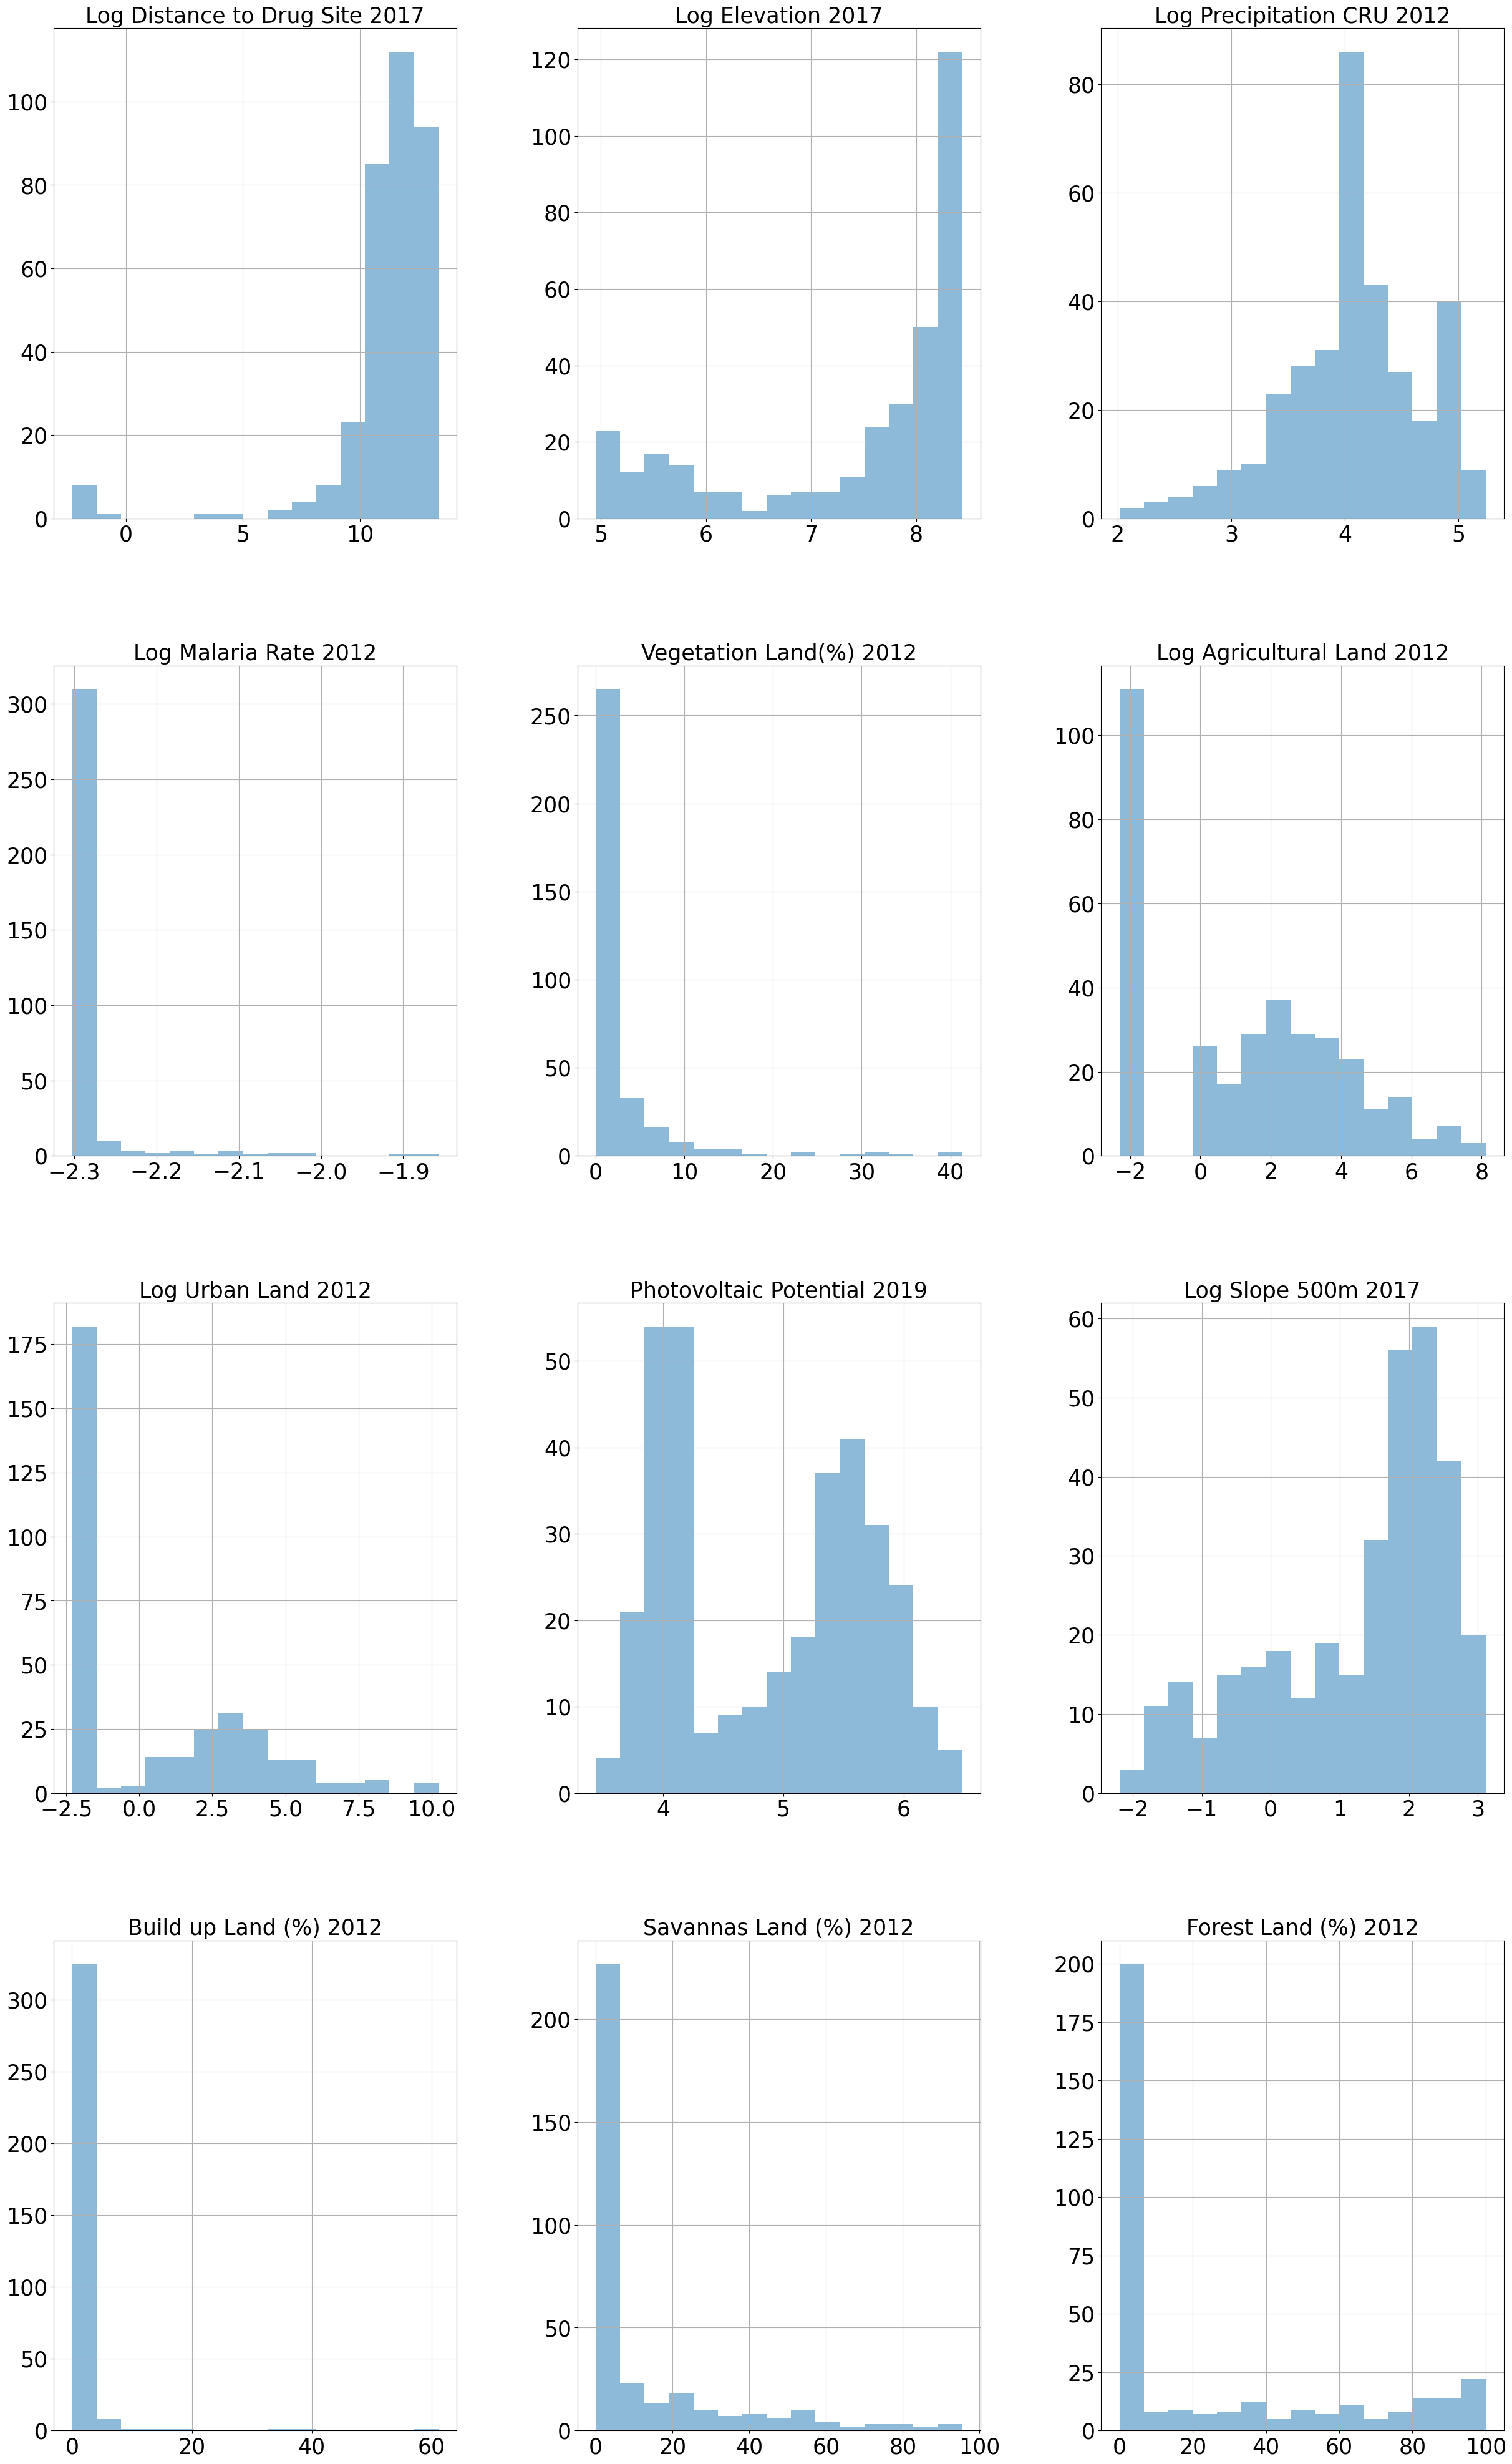

In [ ]:
used = ['ln_dist_drug2017mean', 'ln_elev2017mean','ln_precCRU2012mean', 'ln_mal_inci_rt_max',
         'land_per_area_2012_cropland_natural_vegetation_mosaic', 'lnagr_land2012', 'lnurb_land2012', 'photov2019mean', 
         "ln_slope500m2017mean", 'land_per_area_2012_urban_and_builtup',
         'land_per_area_2012_full_savannas_grasslands', "land_per_area_2012_full_forest"]

plt.rcParams.update({'font.size': 25})
#sat_mod.drop(columns= {"id", 'land_per_area_2012_count'}).hist(bins=15, figsize=(30,50), alpha=0.5)
axes = sat_mod[used].hist(bins=15, figsize=(30,50), alpha=0.5)

titles = ["Log Distance to Drug Site 2017", "Log Elevation 2017", "Log Precipitation CRU 2012", "Log Malaria Rate 2012", 
          "Vegetation Land(%) 2012", "Log Agricultural Land 2012", "Log Urban Land 2012", "Photovoltaic Potential 2019", 
          "Log Slope 500m 2017", "Build up Land (%) 2012", "Savannas Land (%) 2012", "Forest Land (%) 2012"]

for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title, fontsize=25)
plt.show()





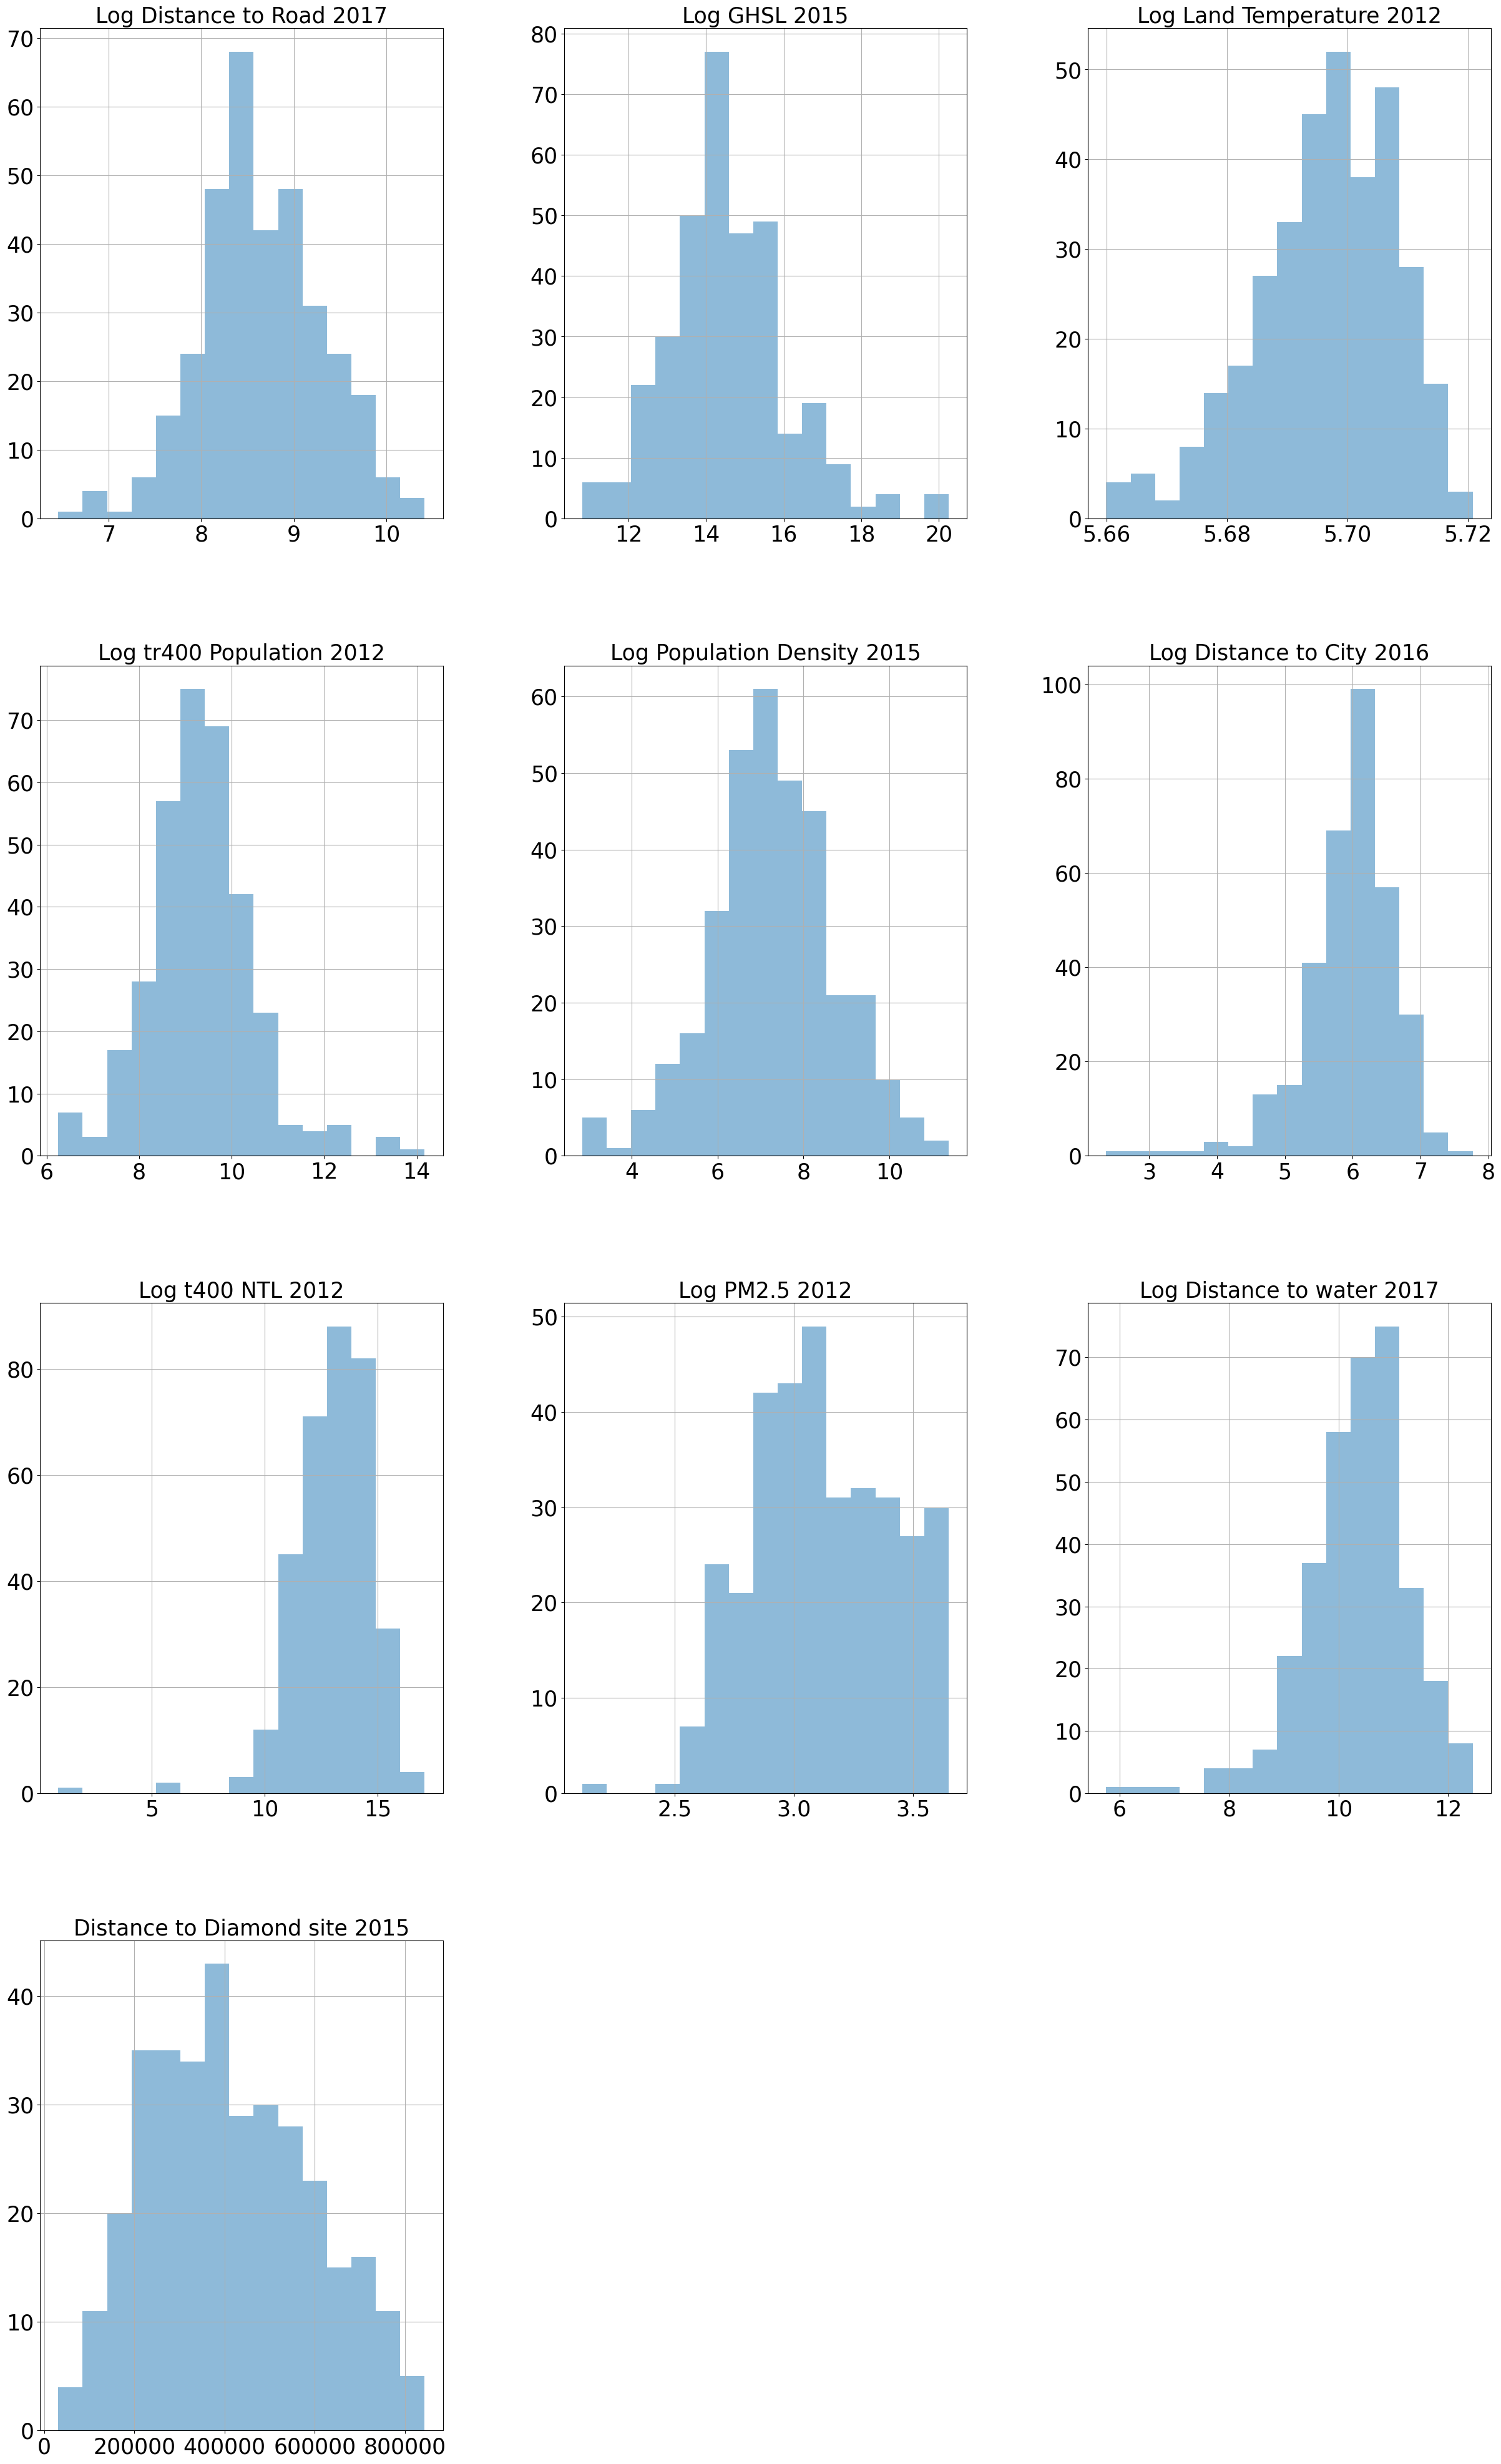

In [ ]:
normal = ['ln_dist_road2017', 'ln_ghsl2015', 'ln_land_temp2012', 'ln_tr400_pop2012', 'ln_density_pop2015count',
          'ln_access2016mean', 'ln_t400NTLpc2012', 'ln_pm25_2012', 'ln_dist_water2017mean', 'dist_diamond2015',]
#sat_mod.drop(columns= {"id", 'land_per_area_2012_count'}).hist(bins=15, figsize=(30,50), alpha=0.5)
plt.rcParams.update({'font.size': 25})

axes = sat_mod[normal].hist(bins=15, figsize=(30,50), alpha=0.5)

titles = ["Log Distance to Road 2017", "Log GHSL 2015", "Log Land Temperature 2012", "Log tr400 Population 2012",
          "Log Population Density 2015", "Log Distance to City 2016", "Log t400 NTL 2012", "Log PM2.5 2012",
          "Log Distance to water 2017", "Distance to Diamond site 2015"]

for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title, fontsize = 25)
plt.show()

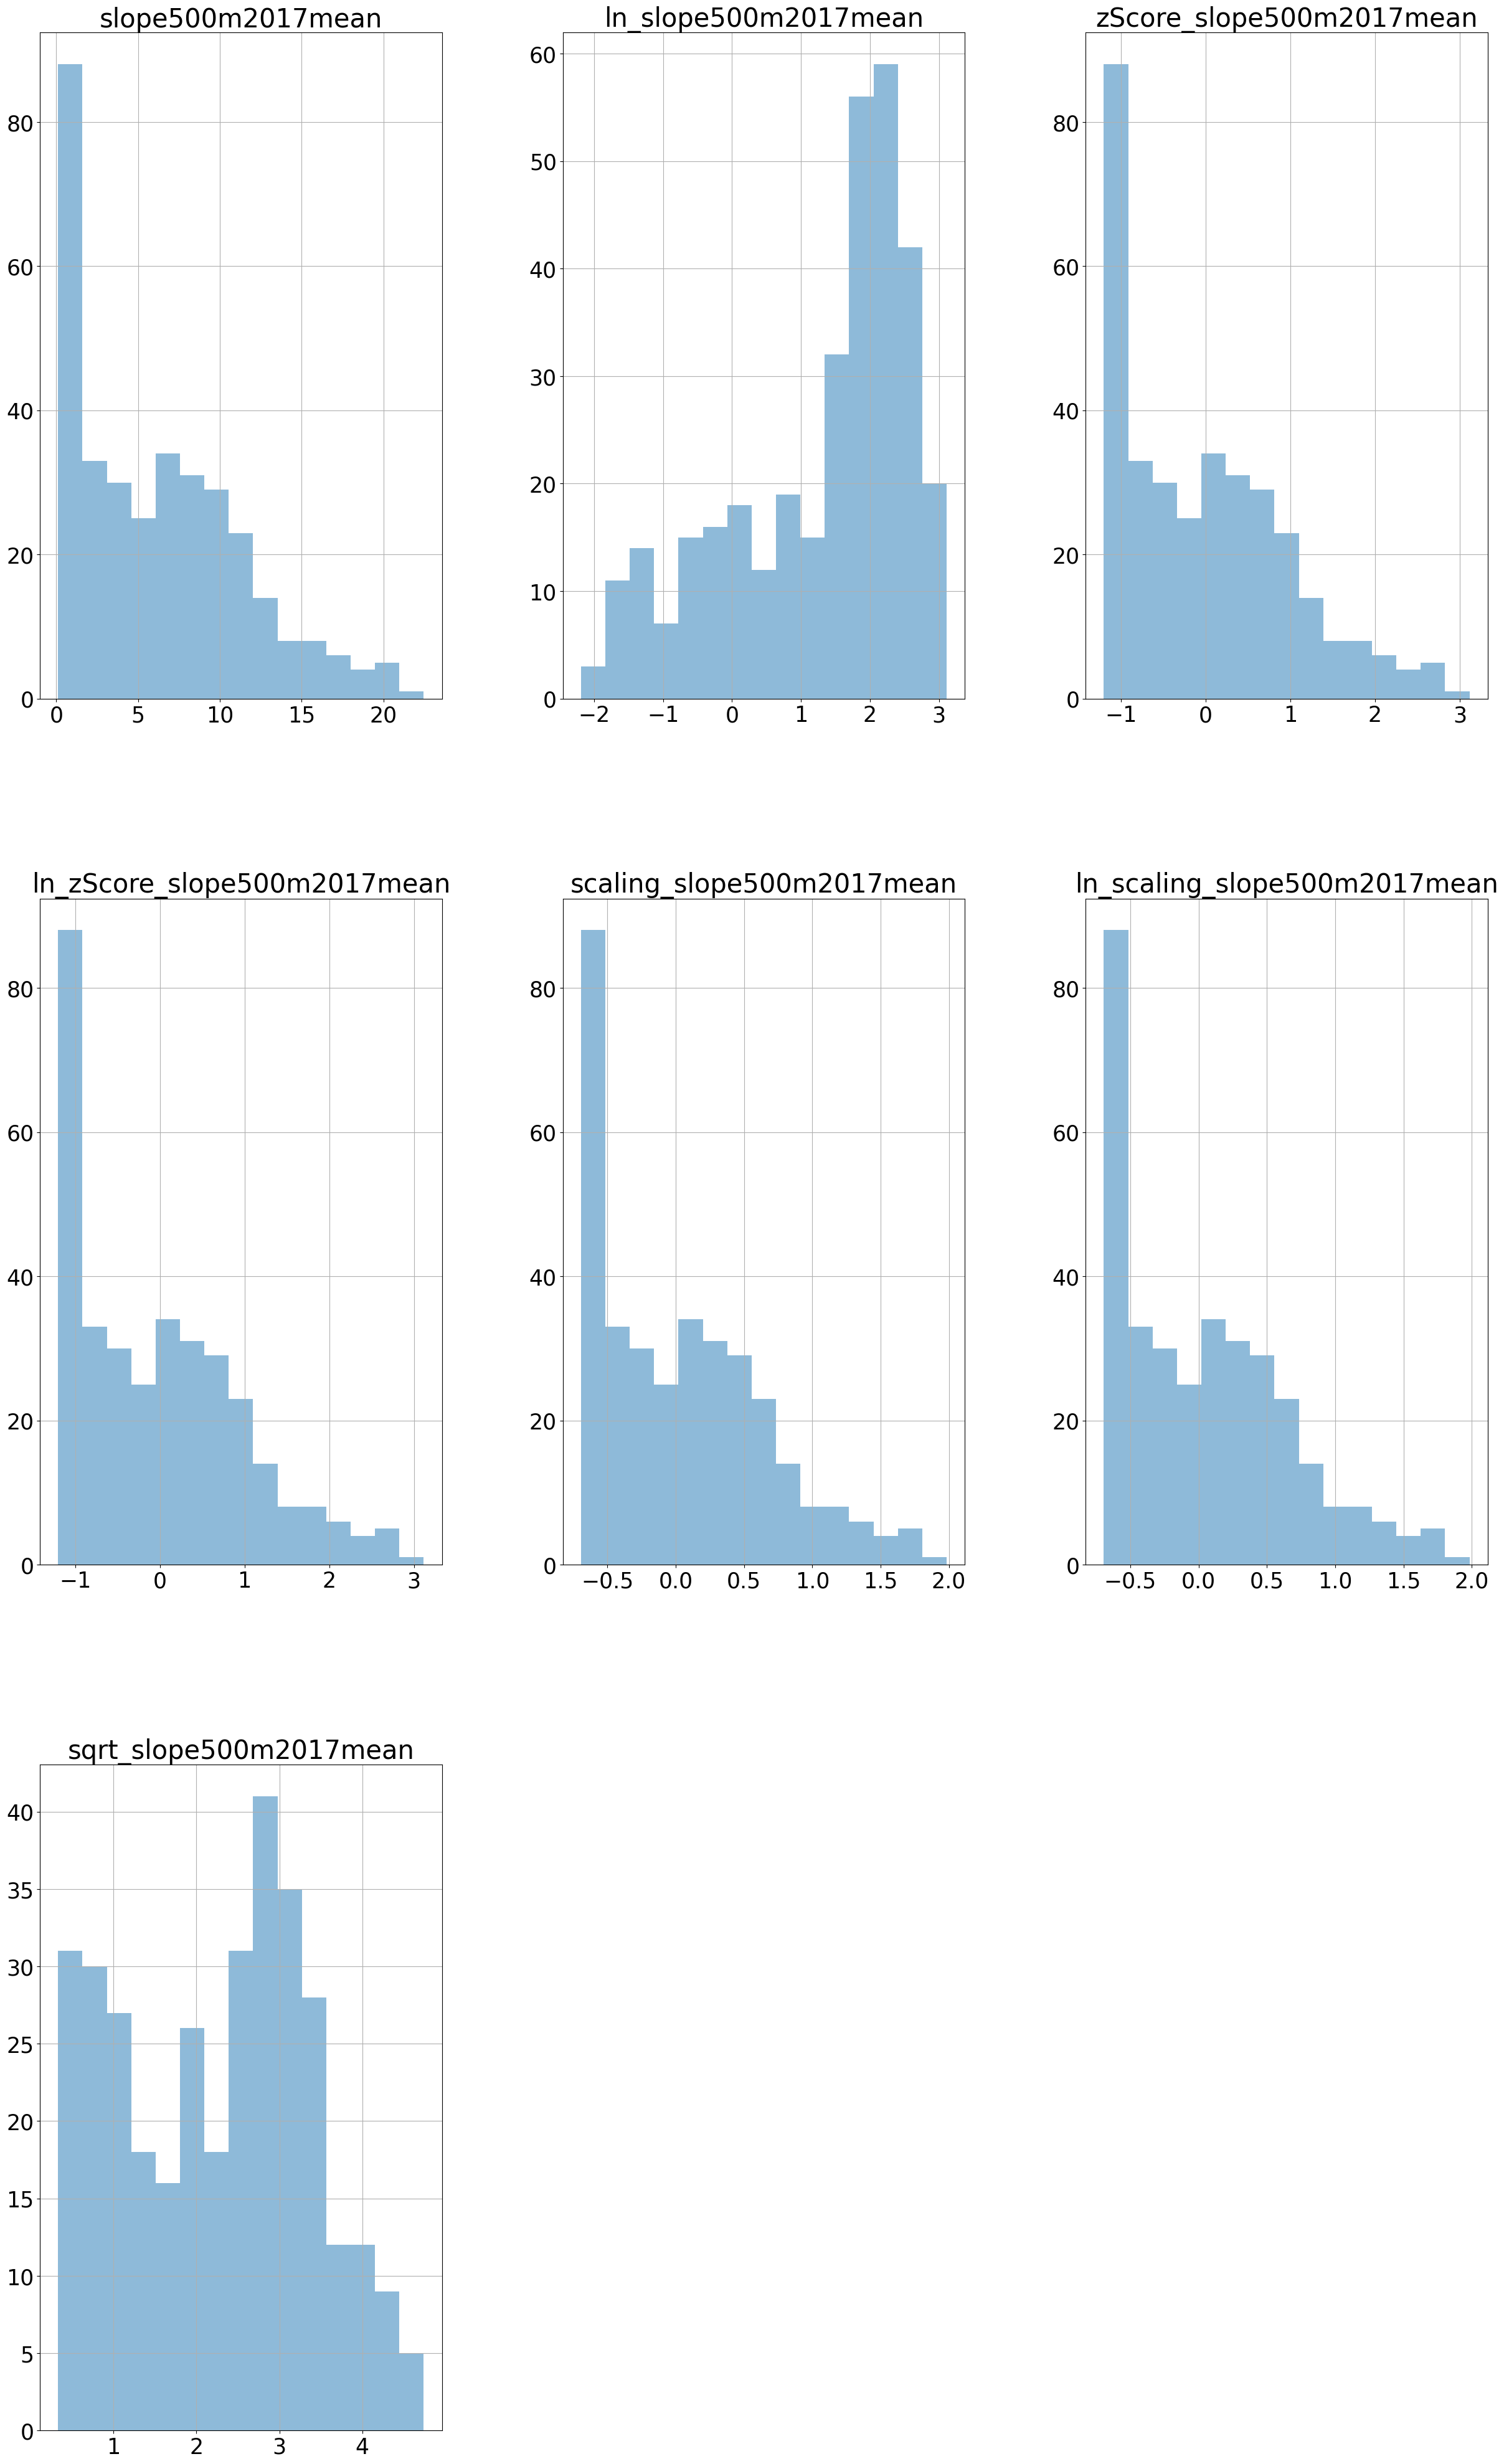

In [ ]:
normal = ["slope500m2017mean", "ln_slope500m2017mean", "zScore_slope500m2017mean", "ln_zScore_slope500m2017mean" ,
          "scaling_slope500m2017mean", "ln_scaling_slope500m2017mean","sqrt_slope500m2017mean"]
#sat_mod.drop(columns= {"id", 'land_per_area_2012_count'}).hist(bins=15, figsize=(30,50), alpha=0.5)
plt.rcParams.update({'font.size': 25})

axes = sat_mod[normal].hist(bins=15, figsize=(30,50), alpha=0.5)

plt.show()

sat_mod["slope500m2017mean"] = slope["slope500m2017mean"]
sat_mod["ln_slope500m2017mean"] = np.log(slope["slope500m2017mean"])
sat_mod["sqrt_slope500m2017mean"] = np.sqrt(slope["slope500m2017mean"])
sat_mod["zScore_slope500m2017mean"] = z_score(slope,"slope500m2017mean")
sat_mod["ln_zScore_slope500m2017mean"] = z_score(slope,"slope500m2017mean")
sat_mod["scaling_slope500m2017mean"] = robust_scaling(slope,"slope500m2017mean")
sat_mod["ln_scaling_slope500m2017mean"] = robust_scaling(slope,"slope500m2017mean")

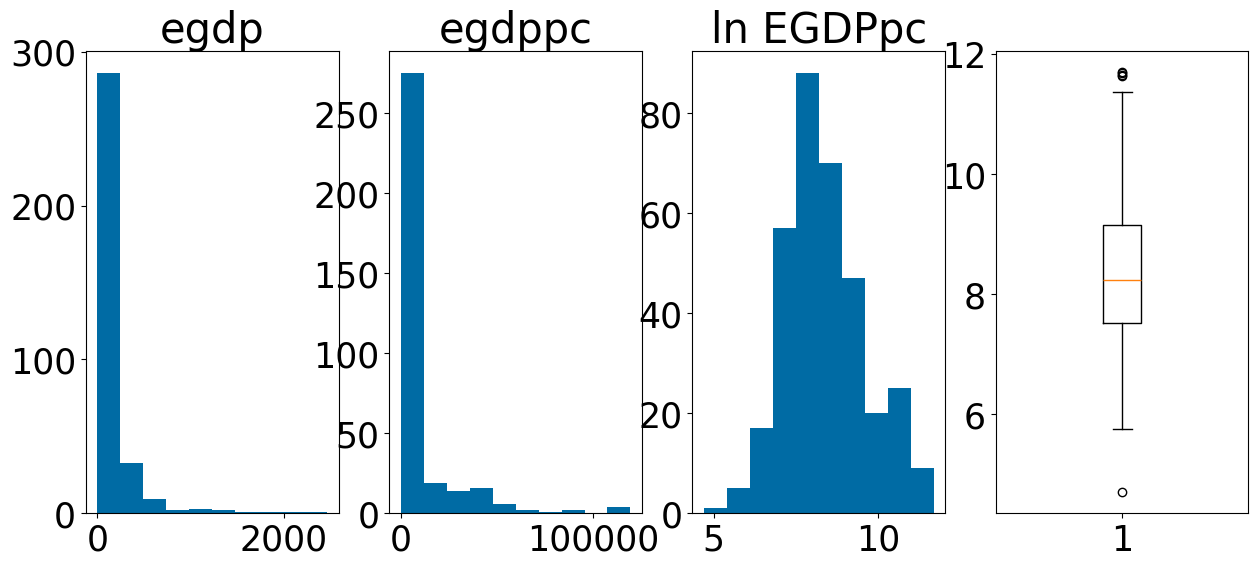

In [ ]:
plt.style.use("tableau-colorblind10")

fig, (ax0, ax1, ax2, ax4) = plt.subplots(nrows=1,
                                 ncols=4,
                                 figsize=(15,6),
                                 alpha=0.5)
ax0.hist(sat["egdp2012"])
ax0.set(title="egdp")

ax1.hist(satellite_full["EGDPpc2012"])
ax1.set(title= "egdppc")

ax2.hist(sat_mod["lnEGDPpc2012"])
ax2.set(title="ln EGDPpc")

ax4.boxplot(sat_mod["lnEGDPpc2012"]);


In [ ]:
#plt.style.available

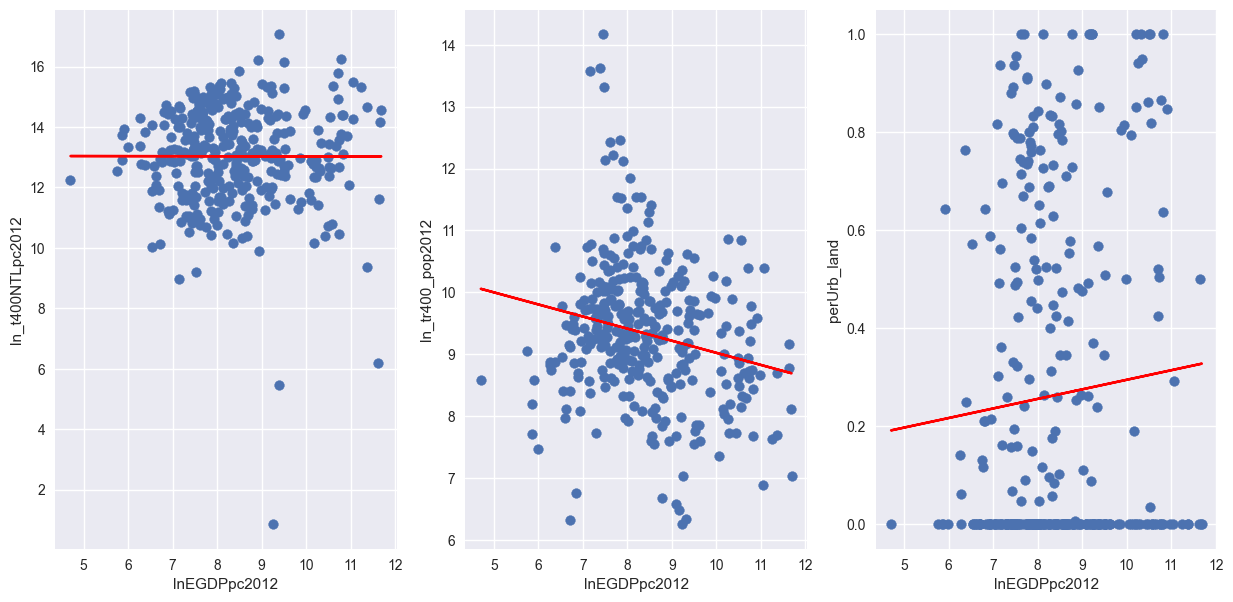

In [ ]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=sat_mod['lnEGDPpc2012'], y=sat_mod["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=sat_mod["lnEGDPpc2012"], y=sat_mod['ln_tr400_pop2012'])
ax1.set(xlabel="lnEGDPpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")

#----- ax2
ax2.scatter(x=sat_mod["lnEGDPpc2012"], y=sat_mod['perUrb_land2012'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="perUrb_land")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['perUrb_land2012'], 1)
p = np.poly1d(z)
ax2.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")



In [ ]:
egdp_ntl = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_t400NTLpc2012'])
egdp_pop = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_tr400_pop2012'])
egdp_urb = sat_mod["lnEGDPpc2012"].corr(sat_mod['perUrb_land2012'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: -0.21141855279870278
Correlation of egdp and Urban land %: 0.06981947820446131


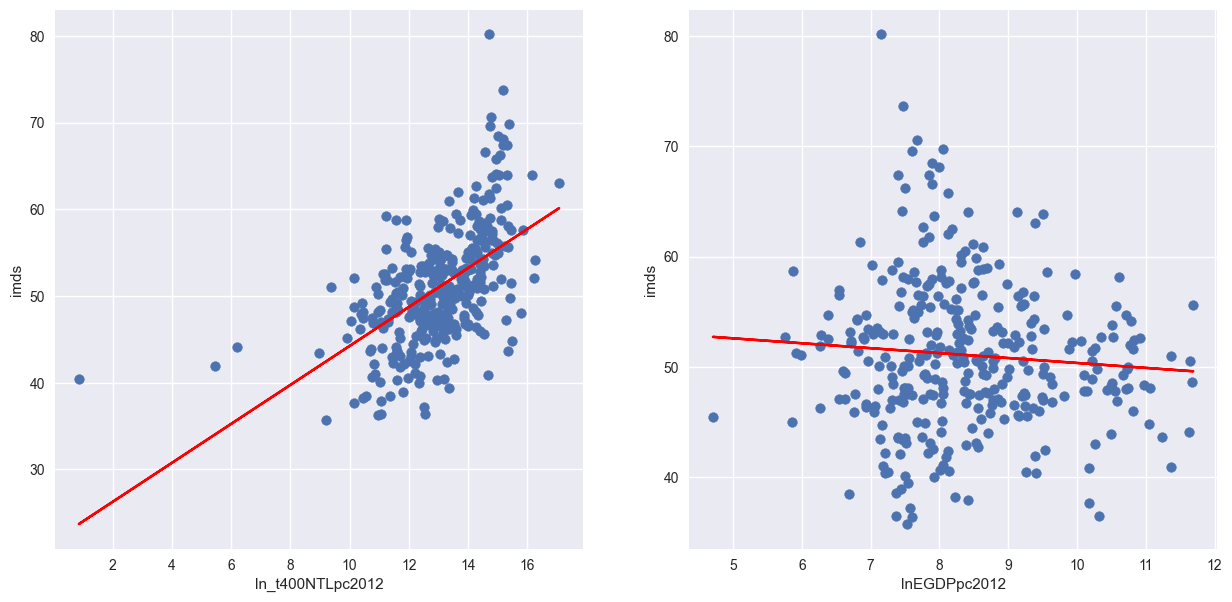

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15,7))

#----- ax1
ax1.scatter(x=sat_mod["ln_t400NTLpc2012"], y=sdg_indexes['imds'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="imds")

# add trendline
z = np.polyfit(sat_mod["ln_t400NTLpc2012"], sdg_indexes['imds'], 1)
p = np.poly1d(z)
ax1.plot(sat_mod["ln_t400NTLpc2012"],p(sat_mod["ln_t400NTLpc2012"]), "r-")

#----- ax2
ax2.scatter(x=sat_mod["lnEGDPpc2012"], y=sdg_indexes['imds'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="imds");

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sdg_indexes['imds'], 1)
p = np.poly1d(z)
ax2.plot(sat_mod["lnEGDPpc2012"], p(sat_mod["lnEGDPpc2012"]), "r-")

In [ ]:
ntl_imds = sat_mod["ln_t400NTLpc2012"].corr(sdg_indexes['imds'])
egdp_imds = sat_mod["lnEGDPpc2012"].corr(sdg_indexes['imds'])

print(f"Correlation of ntl and imds: {ntl_imds}")
print(f"Correlation of egdp and imds: {egdp_imds}")

Correlation of ntl and imds: 0.5548280194761073
Correlation of egdp and imds: -0.08182429944254284


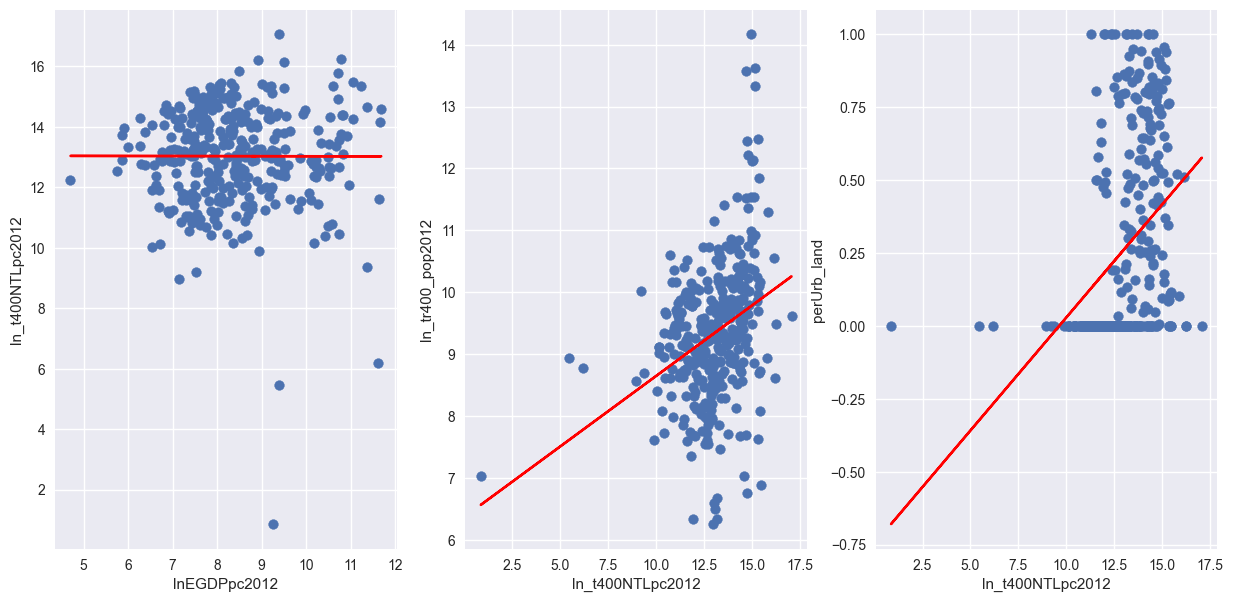

In [ ]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=sat_mod['lnEGDPpc2012'], y=sat_mod["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(sat_mod["lnEGDPpc2012"], sat_mod['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(sat_mod["lnEGDPpc2012"],p(sat_mod["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=sat_mod["ln_t400NTLpc2012"], y=sat_mod['ln_tr400_pop2012'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(sat_mod["ln_t400NTLpc2012"], sat_mod['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(sat_mod["ln_t400NTLpc2012"],p(sat_mod["ln_t400NTLpc2012"]),"r-")

#----- ax2
ax2.scatter(x=sat_mod["ln_t400NTLpc2012"], y=sat_mod['perUrb_land2012'])
ax2.set(xlabel="ln_t400NTLpc2012", ylabel="perUrb_land")

# add trendline
z = np.polyfit(sat_mod["ln_t400NTLpc2012"], sat_mod['perUrb_land2012'], 1)
p = np.poly1d(z)
ax2.plot(sat_mod["ln_t400NTLpc2012"],p(sat_mod["ln_t400NTLpc2012"]),"r-");



In [ ]:
egdp_ntl = sat_mod["lnEGDPpc2012"].corr(sat_mod['ln_t400NTLpc2012'])
egdp_pop = sat_mod["ln_t400NTLpc2012"].corr(sat_mod['ln_tr400_pop2012'])
egdp_urb = sat_mod["ln_t400NTLpc2012"].corr(sat_mod['ln_perUrb_land2012'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: 0.3324972344406324
Correlation of egdp and Urban land %: 0.3744299375753733
